In [1]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
# Save a nice dark grey as a variable
almost_black = '#262626'

import itertools
from unbalanced_dataset import *
from sklearn.decomposition import *
from sklearn import preprocessing, tree, neighbors, cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score
# from sklearn.preprocessing import label_binarize
from sklearn.externals.six import StringIO

from IPython.display import Image 
import pprint
import pydot 
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

# Data Preparation and Setup
## Import the data and declare the properties

In [2]:
filepath = 'data/full_data_genre.csv'

header = None
header_included = True
if header_included:
    header = 0

# different sets of features
genres = ['country', 'dance', 'hip_hop', 'pop', 'r&b', 'rock', 'alternative']
accoustic = ['key', 'energy', 'liveness', 'tempo',
             'speechiness', 'acousticness', 'instrumentalness',
             'danceability', 'time_signature', 'loudness', 'duration', 'mode']
artist = ['artist_familiarity', 'artist_hottness']
# feature properties, 0: numerical, 1: categorical
genres_types = [1,1,1,1,1,1,1]
accoustic_types = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
artist_types = [0, 0]

# features used in prediction
feature_names = accoustic + genres + artist
feature_num = len(feature_names)
feature_types = accoustic_types + genres_types + artist_types 

# predict if the song is in billboard or not
pred_name = 'billboard'
# the percentage of entire dataset using for test dataset
test_percent = 0.3 

df = pd.read_csv(filepath, header = header)
df['billboard'] = df['weeks'].map(lambda x: x != 0)

raw_X = np.array(df[feature_names])
raw_Y = np.array(df[pred_name].map(lambda x: int(x)).tolist())

target_names_bool = list(set(raw_Y.tolist()))

## Another test dataset that is not included in original dataset

In [3]:
new = pd.read_csv('data/new_song.csv', header = header)
new_raw_X = np.array(new[feature_names])
new_raw_Y = np.array(new[pred_name].map(lambda x: int(x)).tolist())

## Classification report options

In [4]:
class Options(object):
    pass

opts = Options()

opts.DTree = False
# opts.lsvc = False

# Save decision tree to pdf
opts.save_DTree = False

# Print a detailed classification report.
opts.print_report = True
# Select some number of features using a chi-squared test
opts.select_chi2 = 3
# Print the confusion matrix.
opts.print_cm = False
# Print normalized confusion matrix.
opts.print_norm_cm = True

## Other functions and class

In [5]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5, 5))
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

In [6]:
class pilot:
    def __init__(self, x, y, dataset_split_random_state = None):
        self.X_train, self.X_test, self.Y_train, self.Y_test = \
        cross_validation.train_test_split(x, y, \
                                          random_state \
                                          = dataset_split_random_state)
    
    def get_dataset(self):
        return self.X_train, self.X_test, self.Y_train, self.Y_test
    
    def benchmark(self,clf):
        t0 = time()
        clf = clf.fit(self.X_train, self.Y_train)
        train_time = time() - t0

        t0 = time()
        Y_predict = clf.predict(self.X_test)
        test_time = time() - t0

        score = accuracy_score(self.Y_test, Y_predict)
        cm = confusion_matrix(self.Y_test, Y_predict)
        report = classification_report(self.Y_test,Y_predict,
                                       target_names = target_names)
        
        print('_' * 80)
        print("Training: ")
        print(clf)
        print()
        print("train time: %0.3fs" % train_time)
        print("test time:  %0.3fs" % test_time)
        print("accuracy:   %0.3f" % score)
        print()
        if opts.print_report:
            print("Classification report:")
            print(report)

        if opts.print_cm:
            plot_confusion_matrix(cm)

        if opts.print_norm_cm:
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            plot_confusion_matrix(cm_normalized, 
                                  title='Normalized confusion matrix')

        if opts.DTree and opts.save_DTree:
            opts.DTree = False
            # save dot file
            with open("data/DTree.dot", 'w') as f:
                f = tree.export_graphviz(clf, out_file=f)
            # save to pdf
            dot_data = StringIO() 
            tree.export_graphviz(clf, out_file=dot_data,  
                                 feature_names=feature_names,  
                                 class_names=target_names,  
                                 filled=True)  
            graph = pydot.graph_from_dot_data(dot_data.getvalue())  
            graph.write_pdf("data/DTree.pdf")
            
        return clf, score, report, train_time, test_time
    
    def DTree(self, **params): # **params set parameters for classifier
        
        clf = tree.DecisionTreeClassifier()

        default_params = clf.get_params(deep=True)
        if params!= {}:
            for key in params:
                if key in default_params:
                    default_params[key] = params[key]

            clf.set_params(class_weight = default_params['class_weight'], 
                           criterion = default_params['criterion'], 
                           max_depth = default_params['max_depth'], 
                           max_leaf_nodes = default_params['max_leaf_nodes'], 
                           min_samples_leaf = default_params['min_samples_leaf'], 
                           min_weight_fraction_leaf \
                           = default_params['min_weight_fraction_leaf'],
                           presort = default_params['presort'], 
                           random_state = default_params['random_state'],
                           splitter = default_params['splitter'])
        
        opts.DTree = True
        return self.benchmark(clf)
    
    
    def KNN(self, **params): # **params set parameters for classifier
        clf = neighbors.KNeighborsClassifier()
        default_params = clf.get_params(deep=True)
        if params!= {}:
            for key in params:
                if key in default_params:
                    default_params[key] = params[key]
                    
        clf.set_params(algorithm = default_params['algorithm'], 
                       leaf_size = default_params['leaf_size'], 
                       metric = default_params['metric'],
                       metric_params = default_params['metric_params'], 
                       n_jobs=default_params['n_jobs'],
                       n_neighbors = default_params['n_neighbors'],
                       p = default_params['p'],
                       weights = default_params['weights'])
        
        return self.benchmark(clf)
    
    def GaussianNaiveBayes(self):
        gnb = GaussianNB()
        return self.benchmark(gnb)
    
    def linearSVC(self, **params):
        lsvc = LinearSVC()
        default_params = lsvc.get_params(deep=True)
        if params!= {}:
            for key in params:
                if key in default_params:
                    default_params[key] = params[key]
                    
        lsvc.set_params(penalty = default_params['penalty'], 
                        loss = default_params['loss'], 
                        dual = default_params['dual'],
                        tol = default_params['tol'], 
                        C=default_params['C'], 
                        multi_class = default_params['multi_class'],
                        fit_intercept = default_params['fit_intercept'],
                        intercept_scaling = default_params['intercept_scaling'],
                        class_weight = default_params['class_weight'],
                        verbose = default_params['verbose'],
                        random_state = default_params['random_state'],
                        max_iter = default_params['max_iter'])
    
        return self.benchmark(lsvc)
    
    def RandomForest(self, **params):
        rfc = RandomForestClassifier()
        return self.benchmark(rfc)    

## Data normalization:
     - numerical data: normalize to range [0, 1]
     - categorical data: label with 0 to k-1

In [7]:
def data_norm(x, y, fnames, ftypes, tnames):
    new_x = np.array(x)

    fnum = len(fnames)
    numerical_features = [fnames[i] for i in range(fnum) if ftypes[i] == 0]
    categorical_features = [fnames[i] for i in range(fnum) if ftypes[i] == 1]

    le = preprocessing.LabelEncoder()

    for i in range(fnum):
        if ftypes[i] == 0:
            new_x[:, i] = preprocessing.minmax_scale(x[:, i],
                                                     feature_range=(-1, 1),
                                                     axis=0, copy=True)
        elif ftypes[i] == 1:
            le.fit(list(set(x[:, i])))
            new_x[:, i] = le.transform(x[:, i]) 

    le.fit(tnames)
    new_y = le.transform(y)
    new_tnames = list(map(str,tnames))
    
    return new_x, new_y, new_tnames

## Data distribution

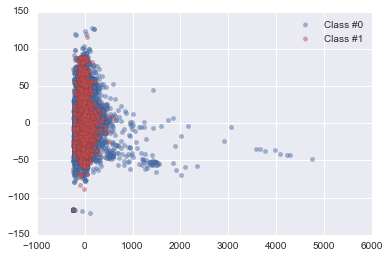

In [8]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(raw_X)
                          
# Plot the original data
# Plot the two classes
palette = sns.color_palette()
plt.scatter(x_vis[raw_Y==0, 0], x_vis[raw_Y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x_vis[raw_Y==1, 0], x_vis[raw_Y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

plt.legend()
plt.show()

**Imbalanced dataset**

In [9]:
X_norm, Y_norm, target_names = \
data_norm(x=raw_X, y=raw_Y, 
          fnames=feature_names, 
          ftypes=feature_types, 
          tnames=target_names_bool)

In [10]:
new_X_norm, new_Y_norm, target_names = \
data_norm(x=new_raw_X, 
          y=new_raw_Y,
          fnames=feature_names, 
          ftypes=feature_types, 
          tnames=target_names_bool)

## Training models and results

In [11]:
example = pilot(X_norm,Y_norm)

________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

train time: 0.437s
test time:  0.002s
accuracy:   0.945

Classification report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      6152
          1       0.93      0.72      0.81      1222

avg / total       0.94      0.94      0.94      7374



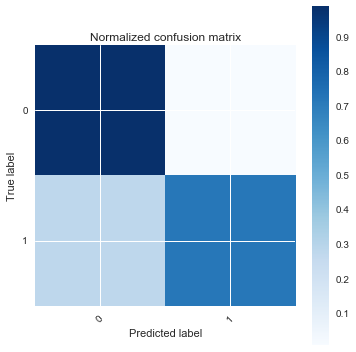

In [12]:
tree_result = example.DTree(min_samples_leaf = 25)

In [13]:
print('prediction:', tree_result[0].predict(new_X_norm))
print('prediction prob:', tree_result[0].predict_proba(new_X_norm,
                                                       check_input=True))

prediction: [0 0 1]
prediction prob: [[ 0.52777778  0.47222222]
 [ 0.77777778  0.22222222]
 [ 0.          1.        ]]


________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

train time: 0.158s
test time:  2.703s
accuracy:   0.876

Classification report:
             precision    recall  f1-score   support

          0       0.88      0.98      0.93      6152
          1       0.79      0.34      0.48      1222

avg / total       0.87      0.88      0.86      7374



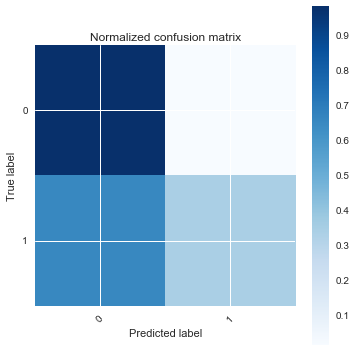

In [14]:
knn_result = example.KNN(n_neighbors = 7)

In [15]:
print('prediction:', knn_result[0].predict(new_X_norm))
print('prediction prob:', knn_result[0].predict_proba(new_X_norm))

prediction: [0 0 0]
prediction prob: [[ 0.71428571  0.28571429]
 [ 1.          0.        ]
 [ 0.85714286  0.14285714]]


________________________________________________________________________________
Training: 
GaussianNB()

train time: 0.026s
test time:  0.020s
accuracy:   0.709

Classification report:
             precision    recall  f1-score   support

          0       0.91      0.73      0.81      6152
          1       0.31      0.62      0.41      1222

avg / total       0.81      0.71      0.74      7374



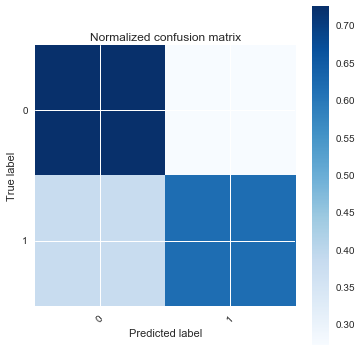

In [16]:
gnb_result = example.GaussianNaiveBayes()

In [17]:
print('prediction:', gnb_result[0].predict(new_X_norm))
try: print('prediction prob:', gnb_result[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 0]
prediction prob: [[  1.00000000e+00   1.44094326e-81]
 [  1.00000000e+00   0.00000000e+00]
 [  9.99999991e-01   9.15952722e-09]]


________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

train time: 4.451s
test time:  0.001s
accuracy:   0.868

Classification report:
             precision    recall  f1-score   support

          0       0.87      0.99      0.93      6152
          1       0.86      0.24      0.38      1222

avg / total       0.87      0.87      0.84      7374



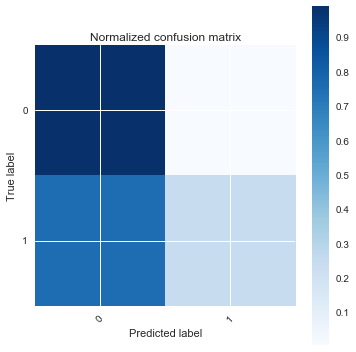

In [18]:
lsvc_result = example.linearSVC()

In [19]:
print('prediction:', lsvc_result[0].predict(new_X_norm))
try:
    print('prediction prob:', lsvc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 1]


________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

train time: 5.971s
test time:  0.001s
accuracy:   0.735

Classification report:
             precision    recall  f1-score   support

          0       0.93      0.74      0.82      6152
          1       0.35      0.73      0.48      1222

avg / total       0.84      0.73      0.77      7374



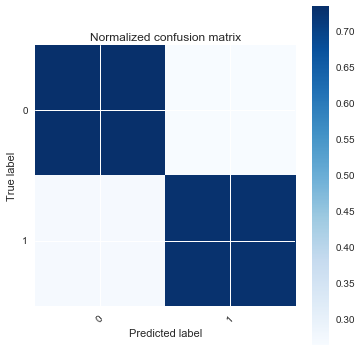

In [20]:
lsvc_result2 = example.linearSVC(class_weight='balanced')

In [21]:
print('prediction:', lsvc_result2[0].predict(new_X_norm))
try:
    print('prediction prob:', lsvc_result2[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 1]


________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

train time: 2.811s
test time:  0.001s
accuracy:   0.731

Classification report:
             precision    recall  f1-score   support

          0       0.93      0.73      0.82      6152
          1       0.35      0.72      0.47      1222

avg / total       0.83      0.73      0.76      7374



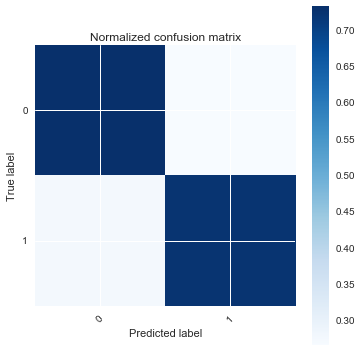

In [22]:
lsvc_result3 = example.linearSVC(class_weight='balanced', 
                                 penalty ='l1', dual = False)

In [23]:
print('prediction:', lsvc_result3[0].predict(new_X_norm))
try: print('prediction prob:', lsvc_result3[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 1]


________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train time: 0.761s
test time:  0.018s
accuracy:   0.936

Classification report:
             precision    recall  f1-score   support

          0       0.93      1.00      0.96      6152
          1       0.97      0.63      0.77      1222

avg / total       0.94      0.94      0.93      7374



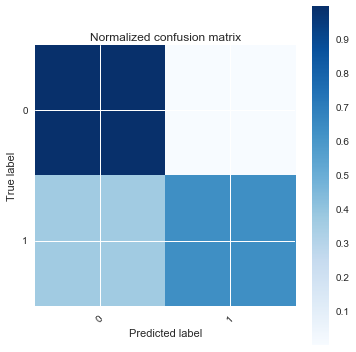

In [24]:
rfc_result = example.RandomForest()

In [25]:
print('prediction:', rfc_result[0].predict(new_X_norm))
print('prediction prob:', rfc_result[0].predict_proba(new_X_norm))

prediction: [1 0 1]
prediction prob: [[ 0.4  0.6]
 [ 0.6  0.4]
 [ 0.2  0.8]]


-------------------------------------------------------------------------------
# Under-Sampling

## Random UnderSampling

In [26]:
sampler = UnderSampler(ratio = 1)
X_under, Y_under = sampler.fit_transform(X_norm,Y_norm)

Determining classes statistics... 2 classes detected: {0: 24756, 1: 4740}
Under-sampling performed: Counter({0: 4740, 1: 4740})


In [27]:
example = pilot(X_under,Y_under)

________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

train time: 0.094s
test time:  0.001s
accuracy:   0.840

Classification report:
             precision    recall  f1-score   support

          0       0.82      0.88      0.85      1202
          1       0.87      0.79      0.83      1168

avg / total       0.84      0.84      0.84      2370



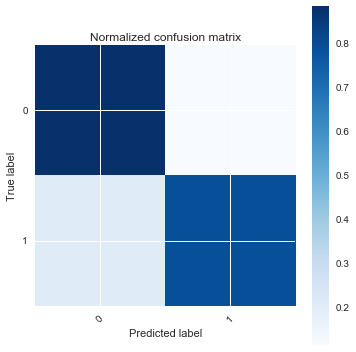

In [28]:
tree_result = example.DTree(min_samples_leaf = 25)

In [29]:
print('prediction:', tree_result[0].predict(new_X_norm))
print('prediction prob:', tree_result[0].predict_proba(new_X_norm))

prediction: [1 0 1]
prediction prob: [[ 0.31818182  0.68181818]
 [ 0.52        0.48      ]
 [ 0.          1.        ]]


________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

train time: 0.032s
test time:  0.303s
accuracy:   0.729

Classification report:
             precision    recall  f1-score   support

          0       0.73      0.75      0.74      1202
          1       0.73      0.71      0.72      1168

avg / total       0.73      0.73      0.73      2370



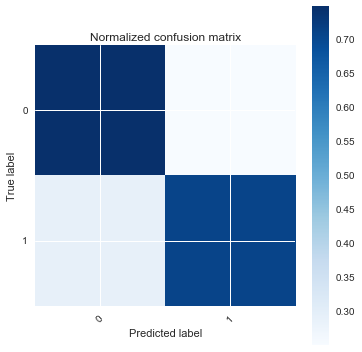

In [30]:
knn_result = example.KNN(n_neighbors = 7)

In [31]:
print('prediction:', knn_result[0].predict(new_X_norm))
try: print('prediction prob:', knn_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 0 1]
prediction prob: [[ 0.42857143  0.57142857]
 [ 0.85714286  0.14285714]
 [ 0.42857143  0.57142857]]


________________________________________________________________________________
Training: 
GaussianNB()

train time: 0.012s
test time:  0.003s
accuracy:   0.673

Classification report:
             precision    recall  f1-score   support

          0       0.73      0.57      0.64      1202
          1       0.64      0.78      0.70      1168

avg / total       0.68      0.67      0.67      2370



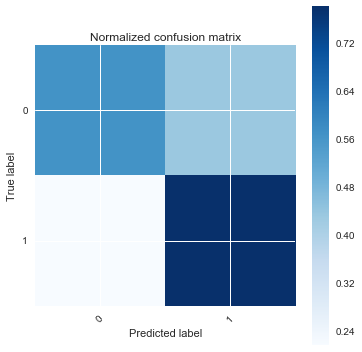

In [32]:
gnb_result = example.GaussianNaiveBayes()

In [33]:
print('prediction:', gnb_result[0].predict(new_X_norm))
try: print('prediction prob:', gnb_result[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 0]
prediction prob: [[  1.00000000e+00   4.24905738e-74]
 [  1.00000000e+00   0.00000000e+00]
 [  9.92790144e-01   7.20985594e-03]]


________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

train time: 1.221s
test time:  0.001s
accuracy:   0.730

Classification report:
             precision    recall  f1-score   support

          0       0.74      0.73      0.73      1202
          1       0.72      0.73      0.73      1168

avg / total       0.73      0.73      0.73      2370



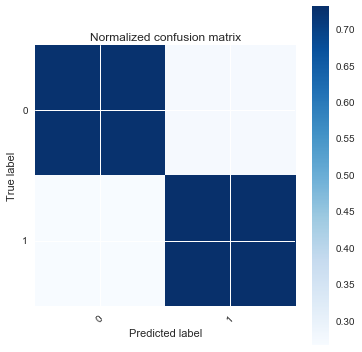

In [34]:
lsvc_result = example.linearSVC()

In [35]:
print('prediction:', lsvc_result[0].predict(new_X_norm))
try: print('prediction prob:', lsvc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 1]


________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train time: 0.197s
test time:  0.007s
accuracy:   0.847

Classification report:
             precision    recall  f1-score   support

          0       0.81      0.91      0.86      1202
          1       0.89      0.79      0.84      1168

avg / total       0.85      0.85      0.85      2370



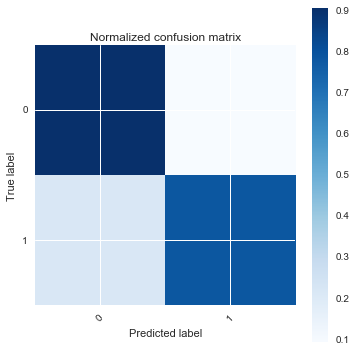

In [36]:
rfc_result = example.RandomForest()

In [37]:
print('prediction:', rfc_result[0].predict(new_X_norm))
try: print('prediction prob:', rfc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 0 0]
prediction prob: [[ 0.2  0.8]
 [ 0.6  0.4]
 [ 0.5  0.5]]


## NearMiss

In [38]:
sampler = NearMiss()
X_nm, Y_nm = sampler.fit_transform(X_norm,Y_norm)

Determining classes statistics... 2 classes detected: {0: 24756, 1: 4740}
Under-sampling performed: Counter({0: 4740, 1: 4740})


In [39]:
example = pilot(X_nm,Y_nm)

________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

train time: 0.101s
test time:  0.001s
accuracy:   0.845

Classification report:
             precision    recall  f1-score   support

          0       0.81      0.89      0.85      1157
          1       0.88      0.81      0.84      1213

avg / total       0.85      0.85      0.85      2370



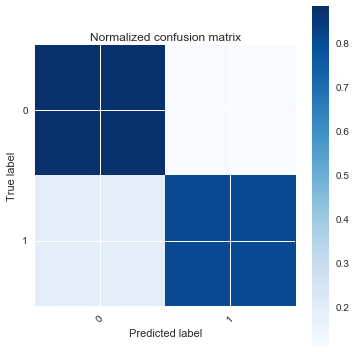

In [40]:
tree_result = example.DTree(min_samples_leaf = 25)

In [41]:
print('prediction:', tree_result[0].predict(new_X_norm))
try:print('prediction prob:', tree_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 1 1]
prediction prob: [[ 0.11428571  0.88571429]
 [ 0.44        0.56      ]
 [ 0.          1.        ]]


________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

train time: 0.020s
test time:  0.205s
accuracy:   0.735

Classification report:
             precision    recall  f1-score   support

          0       0.67      0.89      0.77      1157
          1       0.85      0.58      0.69      1213

avg / total       0.76      0.73      0.73      2370



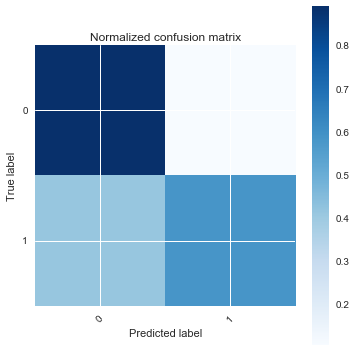

In [42]:
knn_result = example.KNN(n_neighbors = 7)

In [43]:
print('prediction:', knn_result[0].predict(new_X_norm))
try: print('prediction prob:', knn_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 1 1]
prediction prob: [[ 0.28571429  0.71428571]
 [ 0.28571429  0.71428571]
 [ 0.          1.        ]]


________________________________________________________________________________
Training: 
GaussianNB()

train time: 0.009s
test time:  0.002s
accuracy:   0.648

Classification report:
             precision    recall  f1-score   support

          0       0.60      0.85      0.70      1157
          1       0.76      0.46      0.57      1213

avg / total       0.68      0.65      0.63      2370



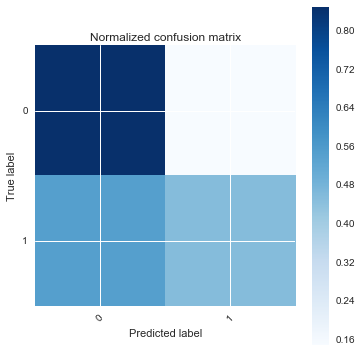

In [44]:
gnb_result = example.GaussianNaiveBayes()

In [45]:
print('prediction:', gnb_result[0].predict(new_X_norm))
try: print('prediction prob:', gnb_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 0 1]
prediction prob: [[  2.52295459e-32   1.00000000e+00]
 [  1.00000000e+00   7.23810797e-62]
 [  6.87273626e-75   1.00000000e+00]]


________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

train time: 1.187s
test time:  0.001s
accuracy:   0.732

Classification report:
             precision    recall  f1-score   support

          0       0.70      0.78      0.74      1157
          1       0.76      0.69      0.72      1213

avg / total       0.73      0.73      0.73      2370



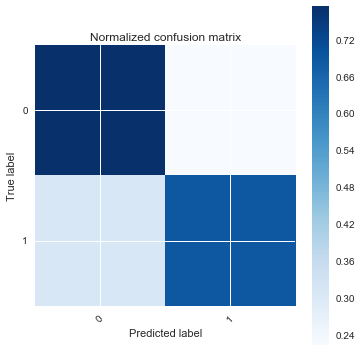

In [46]:
lsvc_result = example.linearSVC()

In [47]:
print('prediction:', lsvc_result[0].predict(new_X_norm))
try: print('prediction prob:', lsvc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 1]


________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train time: 0.212s
test time:  0.007s
accuracy:   0.849

Classification report:
             precision    recall  f1-score   support

          0       0.81      0.90      0.85      1157
          1       0.89      0.80      0.84      1213

avg / total       0.85      0.85      0.85      2370



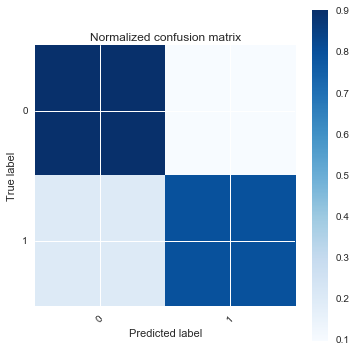

In [48]:
rfc_result = example.RandomForest()

In [49]:
print('prediction:', rfc_result[0].predict(new_X_norm))
try: print('prediction prob:', rfc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 1 1]
prediction prob: [[ 0.3  0.7]
 [ 0.2  0.8]
 [ 0.1  0.9]]


----------------------------------------------------------------------------------------------
# Over-Sampling

## Random OverSampling

In [50]:
sampler = OverSampler(ratio = 4)
X_os, Y_os = sampler.fit_transform(X_norm,Y_norm)

Determining classes statistics... 2 classes detected: {0: 24756, 1: 4740}
Over-sampling performed: Counter({0: 24756, 1: 23700})


In [51]:
example = pilot(X_os,Y_os)

________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

train time: 0.578s
test time:  0.003s
accuracy:   0.913

Classification report:
             precision    recall  f1-score   support

          0       0.91      0.93      0.92      6295
          1       0.92      0.90      0.91      5819

avg / total       0.91      0.91      0.91     12114



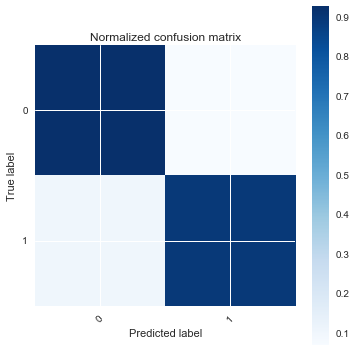

In [52]:
tree_result = example.DTree(min_samples_leaf = 25)

In [53]:
print('prediction:', tree_result[0].predict(new_X_norm))
try: print('prediction prob:', tree_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 0 1]
prediction prob: [[ 0.36  0.64]
 [ 1.    0.  ]
 [ 0.    1.  ]]


________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

train time: 0.308s
test time:  7.791s
accuracy:   0.828

Classification report:
             precision    recall  f1-score   support

          0       0.87      0.79      0.83      6295
          1       0.79      0.87      0.83      5819

avg / total       0.83      0.83      0.83     12114



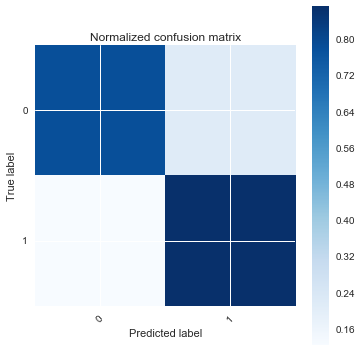

In [54]:
knn_result = example.KNN(n_neighbors = 7)

In [55]:
print('prediction:', knn_result[0].predict(new_X_norm))
try:print('prediction prob:', knn_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 0 0]
prediction prob: [[ 0.42857143  0.57142857]
 [ 1.          0.        ]
 [ 0.57142857  0.42857143]]


________________________________________________________________________________
Training: 
GaussianNB()

train time: 0.051s
test time:  0.014s
accuracy:   0.675

Classification report:
             precision    recall  f1-score   support

          0       0.75      0.56      0.64      6295
          1       0.63      0.80      0.70      5819

avg / total       0.69      0.67      0.67     12114



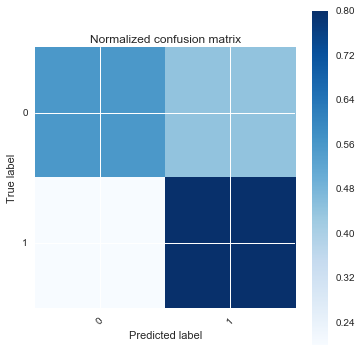

In [56]:
gnb_result = example.GaussianNaiveBayes()

In [57]:
print('prediction:', gnb_result[0].predict(new_X_norm))
try:print('prediction prob:', gnb_result[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 0]
prediction prob: [[  1.00000000e+00   2.10437193e-86]
 [  1.00000000e+00   0.00000000e+00]
 [  9.99999998e-01   2.40820383e-09]]


________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

train time: 11.498s
test time:  0.002s
accuracy:   0.732

Classification report:
             precision    recall  f1-score   support

          0       0.74      0.74      0.74      6295
          1       0.72      0.72      0.72      5819

avg / total       0.73      0.73      0.73     12114



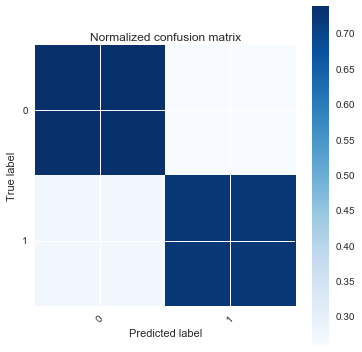

In [58]:
lsvc_result = example.linearSVC()

In [59]:
print('prediction:', lsvc_result[0].predict(new_X_norm))
try:print('prediction prob:', lsvc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [0 0 1]


________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train time: 0.841s
test time:  0.029s
accuracy:   0.991

Classification report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      6295
          1       0.99      0.99      0.99      5819

avg / total       0.99      0.99      0.99     12114



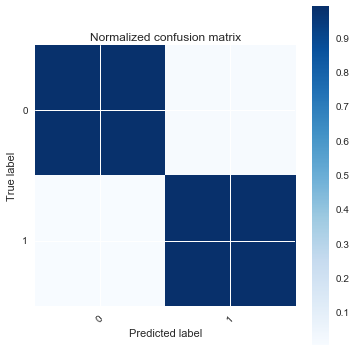

In [60]:
rfc_result = example.RandomForest()

In [61]:
print('prediction:', rfc_result[0].predict(new_X_norm))
try:print('prediction prob:', rfc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 0 0]
prediction prob: [[ 0.4  0.6]
 [ 0.5  0.5]
 [ 0.6  0.4]]


## SMOTE

In [62]:
sampler = SMOTE(ratio = 4)
X_smote, Y_smote = sampler.fit_transform(X_norm,Y_norm)

In [63]:
example = pilot(X_smote,Y_smote)

________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

train time: 0.597s
test time:  0.003s
accuracy:   0.937

Classification report:
             precision    recall  f1-score   support

          0       0.92      0.96      0.94      6117
          1       0.95      0.92      0.93      5997

avg / total       0.94      0.94      0.94     12114



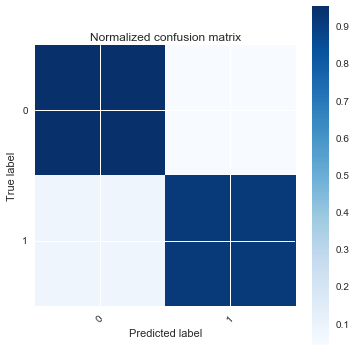

In [64]:
tree_result = example.DTree(min_samples_leaf = 25)

In [65]:
print('prediction:', tree_result[0].predict(new_X_norm))
try: print('prediction prob:', tree_result[0].predict_proba(new_X_norm))
except: pass

prediction: [ 0.  0.  1.]
prediction prob: [[ 1.          0.        ]
 [ 0.69230769  0.30769231]
 [ 0.          1.        ]]


________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

train time: 0.282s
test time:  7.598s
accuracy:   0.863

Classification report:
             precision    recall  f1-score   support

          0       0.93      0.79      0.85      6117
          1       0.81      0.94      0.87      5997

avg / total       0.87      0.86      0.86     12114



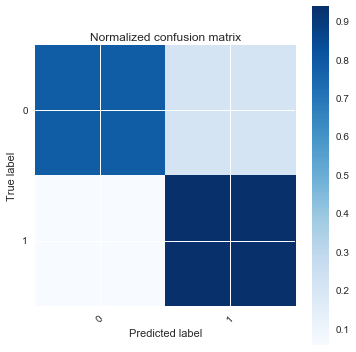

In [66]:
knn_result = example.KNN(n_neighbors = 7)

In [67]:
print('prediction:', knn_result[0].predict(new_X_norm))
try: print('prediction prob:', knn_result[0].predict_proba(new_X_norm))
except: pass

prediction: [ 1.  0.  0.]
prediction prob: [[ 0.42857143  0.57142857]
 [ 1.          0.        ]
 [ 0.57142857  0.42857143]]


________________________________________________________________________________
Training: 
GaussianNB()

train time: 0.040s
test time:  0.011s
accuracy:   0.696

Classification report:
             precision    recall  f1-score   support

          0       0.77      0.57      0.65      6117
          1       0.65      0.83      0.73      5997

avg / total       0.71      0.70      0.69     12114



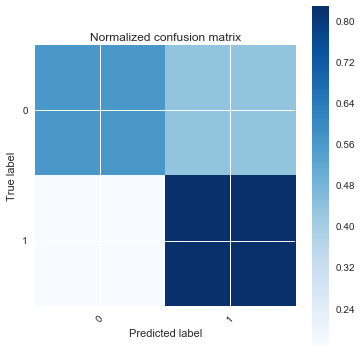

In [68]:
gnb_result = example.GaussianNaiveBayes()

In [69]:
print('prediction:', gnb_result[0].predict(new_X_norm))
try: print('prediction prob:', gnb_result[0].predict_proba(new_X_norm))
except: pass

prediction: [ 0.  0.  0.]
prediction prob: [[  1.00000000e+000   6.81969418e-127]
 [  1.00000000e+000   0.00000000e+000]
 [  1.00000000e+000   5.48395429e-025]]


________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

train time: 9.758s
test time:  0.001s
accuracy:   0.750

Classification report:
             precision    recall  f1-score   support

          0       0.75      0.76      0.75      6117
          1       0.75      0.74      0.75      5997

avg / total       0.75      0.75      0.75     12114



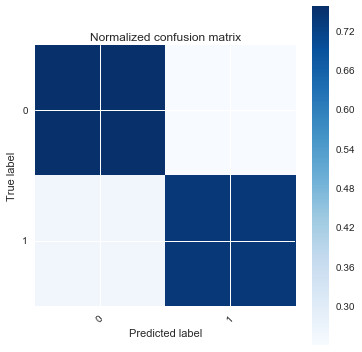

In [70]:
lsvc_result = example.linearSVC()

In [71]:
print('prediction:', lsvc_result[0].predict(new_X_norm))
try:print('prediction prob:', lsvc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [ 0.  0.  1.]


________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train time: 1.074s
test time:  0.031s
accuracy:   0.957

Classification report:
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      6117
          1       0.98      0.93      0.96      5997

avg / total       0.96      0.96      0.96     12114



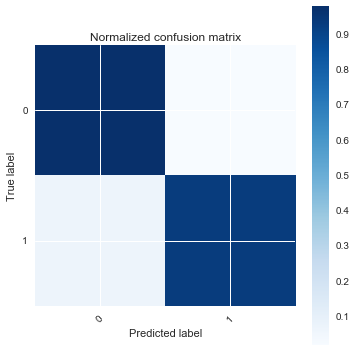

In [72]:
rfc_result = example.RandomForest()

In [73]:
print('prediction:', rfc_result[0].predict(new_X_norm))
try:print('prediction prob:', rfc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [ 1.  1.  0.]
prediction prob: [[ 0.4  0.6]
 [ 0.4  0.6]
 [ 0.7  0.3]]
